In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
from torchinfo import summary
from adopt import ADOPT
import os
import warnings


In [2]:
warnings.filterwarnings("ignore")
torch.cuda.empty_cache()

In [ ]:
print(sorted(os.listdir("BIG_DATA/2008/")))

['200801.gzip', '200802.gzip', '200803.gzip', '200804.gzip', '200805.gzip', '200806.gzip', '200807.gzip', '200808.gzip', '200809.gzip', '200810.gzip']


In [4]:
def collect_data(directory_path):
    
    files = sorted(os.listdir(directory_path))
    data = pd.read_parquet(directory_path + files[0])
    data.drop(['LQFRAC'], axis = 1, inplace = True)
    data.rename(columns={'Unnamed: 0': 'time'}, inplace=True)
    for i in range(1,len(os.listdir(directory_path))):
        data_intermediate = pd.read_parquet(directory_path + files[i])
        data_intermediate.rename(columns={'Unnamed: 0': 'time'}, inplace=True)
        data_intermediate.drop(['LQFRAC'], axis = 1, inplace = True)
        data = pd.concat([data, data_intermediate], axis = 0)

    
    return data 

In [5]:
data = collect_data("BIG_DATA/2008/")

In [6]:
print(data.shape)
print(data.columns)

(7319943, 56)
Index(['time', 'comid', 'catid', 'du', 'pair_id', 'U2D', 'V2D', 'LWDOWN',
       'RAINRATE', 'T2D', 'Q2D', 'PSFC', 'SWDOWN', 'streamflow',
       'elevation_mean', 'slope_mean', 'impervious_mean', 'aspect_c_mean',
       'twi_dist_4', 'X', 'Y', 'gw_Coeff', 'gw_Zmax', 'gw_Expon',
       'bexp_soil_layers_stag=1', 'bexp_soil_layers_stag=2',
       'bexp_soil_layers_stag=3', 'bexp_soil_layers_stag=4', 'ISLTYP',
       'IVGTYP', 'dksat_soil_layers_stag=1', 'dksat_soil_layers_stag=2',
       'dksat_soil_layers_stag=3', 'dksat_soil_layers_stag=4',
       'psisat_soil_layers_stag=1', 'psisat_soil_layers_stag=2',
       'psisat_soil_layers_stag=3', 'psisat_soil_layers_stag=4', 'cwpvt',
       'mfsno', 'mp', 'quartz_soil_layers_stag=1', 'quartz_soil_layers_stag=2',
       'quartz_soil_layers_stag=3', 'quartz_soil_layers_stag=4', 'refkdt',
       'slope', 'smcmax_soil_layers_stag=1', 'smcmax_soil_layers_stag=2',
       'smcmax_soil_layers_stag=3', 'smcmax_soil_layers_stag=4',
     

In [7]:
print(f"The number of features available to us: {data.shape[1]}")
print(data.columns)

The number of features available to us: 56
Index(['time', 'comid', 'catid', 'du', 'pair_id', 'U2D', 'V2D', 'LWDOWN',
       'RAINRATE', 'T2D', 'Q2D', 'PSFC', 'SWDOWN', 'streamflow',
       'elevation_mean', 'slope_mean', 'impervious_mean', 'aspect_c_mean',
       'twi_dist_4', 'X', 'Y', 'gw_Coeff', 'gw_Zmax', 'gw_Expon',
       'bexp_soil_layers_stag=1', 'bexp_soil_layers_stag=2',
       'bexp_soil_layers_stag=3', 'bexp_soil_layers_stag=4', 'ISLTYP',
       'IVGTYP', 'dksat_soil_layers_stag=1', 'dksat_soil_layers_stag=2',
       'dksat_soil_layers_stag=3', 'dksat_soil_layers_stag=4',
       'psisat_soil_layers_stag=1', 'psisat_soil_layers_stag=2',
       'psisat_soil_layers_stag=3', 'psisat_soil_layers_stag=4', 'cwpvt',
       'mfsno', 'mp', 'quartz_soil_layers_stag=1', 'quartz_soil_layers_stag=2',
       'quartz_soil_layers_stag=3', 'quartz_soil_layers_stag=4', 'refkdt',
       'slope', 'smcmax_soil_layers_stag=1', 'smcmax_soil_layers_stag=2',
       'smcmax_soil_layers_stag=3', 'smcm

In [8]:
data.drop(['bexp_soil_layers_stag=2',
       'bexp_soil_layers_stag=3', 'bexp_soil_layers_stag=4', 'dksat_soil_layers_stag=2',
       'dksat_soil_layers_stag=3', 'dksat_soil_layers_stag=4', 'psisat_soil_layers_stag=2',
       'psisat_soil_layers_stag=3', 'psisat_soil_layers_stag=4', 'quartz_soil_layers_stag=2',
       'quartz_soil_layers_stag=3', 'quartz_soil_layers_stag=4', 'smcmax_soil_layers_stag=2',
       'smcmax_soil_layers_stag=3', 'smcmax_soil_layers_stag=4','smcwlt_soil_layers_stag=2',
       'smcwlt_soil_layers_stag=3', 'smcwlt_soil_layers_stag=4',  'bexp_soil_layers_stag=1', 'cwpvt', 'mp', 'quartz_soil_layers_stag=1', 'vcmx25', 'aspect_c_mean', 'gw_Coeff', 'gw_Zmax', 'gw_Expon', 'psisat_soil_layers_stag=1', 'smcmax_soil_layers_stag=1', 'smcwlt_soil_layers_stag=1', 'refkdt'], axis = 1, inplace = True)
print(f"After dropping a few columns, the number of new features available to us is: {len(data.columns)}")

After dropping a few columns, the number of new features available to us is: 25


In [9]:
def load_data_in_dictionary(data):
    '''This loads the data into a dictionary. each index of dictionary has a pair of watersheds, 
       upper and lower, and their features are merged in the for loop below'''
    num_networks = 0
    network_dict = {}
    broken_pairs = []
    for i in range(int((data['pair_id']).max())+1):
        downstream = data[(data['pair_id']== i) & (data['du'] == 'd')]
        upstream = data[(data['pair_id']== i) & (data['du'] == 'u')]
        #print(downstream)
        #print(upstream)
        if downstream.empty or downstream.isnull().values.any():
            print(i, " DS is empty")
            continue
        if upstream.empty or upstream.isnull().values.any():
            print(i, " US is empty or the upstream flow is constant")
            continue
        '''area_ratio = upstream.iloc[0]["Shape_Area"] / downstream.iloc[0]["Shape_Area"]
        if area_ratio > 1:
            print(i, " area ratio too large")
            continue
        if abs(downstream.iloc[-1]['ID'] - upstream.iloc[-1]['ID']) > 100:
            print(i, " DS and US too far apart")
            continue'''
        network = downstream.merge(upstream, on="time")
        network_dict[num_networks] = network
        num_networks += 1

    real_id = 0
    for key in network_dict.keys():
        if key != real_id:
            network_dict[real_id] = network_dict.pop(key)
        real_id += 1

    return network_dict, broken_pairs, num_networks, network



network_dict, broken_pairs, num_networks, network = load_data_in_dictionary(data)

print(f"The number of networks we have:\t{len(network_dict)}")
print(f"The number of data points in each network:\t{network_dict[0].shape[0]}")
print(f"The number of features in each network:\t{network_dict[0].shape[1]}")

33  DS is empty
36  US is empty or the upstream flow is constant
65  US is empty or the upstream flow is constant
169  DS is empty
170  US is empty or the upstream flow is constant
195  US is empty or the upstream flow is constant
199  DS is empty
270  US is empty or the upstream flow is constant
281  DS is empty
291  DS is empty
303  DS is empty
331  DS is empty
390  US is empty or the upstream flow is constant
425  US is empty or the upstream flow is constant
457  US is empty or the upstream flow is constant
The number of networks we have:	485
The number of data points in each network:	7320
The number of features in each network:	49


In [10]:
print(network_dict[18])

                     time   comid_x     catid_x du_x  pair_id_x     U2D_x  \
0     2008-01-01 00:00:00  16808155  cat-418010    d       18.0 -0.300478   
1     2008-01-01 01:00:00  16808155  cat-418010    d       18.0 -0.200000   
2     2008-01-01 02:00:00  16808155  cat-418010    d       18.0  0.000000   
3     2008-01-01 03:00:00  16808155  cat-418010    d       18.0  0.200000   
4     2008-01-01 04:00:00  16808155  cat-418010    d       18.0  0.424453   
...                   ...       ...         ...  ...        ...       ...   
7315  2008-10-31 19:00:00  16808155  cat-418010    d       18.0 -2.645714   
7316  2008-10-31 20:00:00  16808155  cat-418010    d       18.0 -2.700000   
7317  2008-10-31 21:00:00  16808155  cat-418010    d       18.0 -2.799417   
7318  2008-10-31 22:00:00  16808155  cat-418010    d       18.0 -2.804335   
7319  2008-10-31 23:00:00  16808155  cat-418010    d       18.0 -2.894562   

         V2D_x    LWDOWN_x  RAINRATE_x       T2D_x  ...  slope_mean_y  \
0 

In [11]:
network.drop(['time', 'comid_x', 'catid_x', 'du_x', 'pair_id_x', 'twi_dist_4_x', 'comid_y', 'catid_y', 'du_y', 'pair_id_y', 'twi_dist_4_y', "X_x", "Y_x", "X_y", "Y_y"], axis = 1, inplace=True)

In [12]:
reduced_features = network.columns.to_list()

In [13]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Using CUDA device:", torch.cuda.get_device_name(0))
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple M3/M2/M1 (Metal) device")
else:
    device = 'cpu'
    print("Using CPU")

# batch_size = 1704
seq_length = 550

Using CUDA device: NVIDIA GeForce RTX 3060


In [14]:
n_networks = len(network_dict)

n_networks_split = {"train": (math.floor(n_networks * 0.7)), "val": math.floor(n_networks * 0.2), "test": math.floor(n_networks * 0.1)}
print(n_networks_split['val'])

97


In [15]:
def split_parameters(n_networks):
    # create lists of network indices for each set based on the given network splits
    networks_for_training = list(range(0, n_networks_split['train'] + 1))
    networks_for_val = list(range(n_networks_split['train'] + 1, 
                                 n_networks_split['train'] + n_networks_split['val'] + 1))

    if (n_networks_split['test'] > 0):
        networks_for_test = list(range(n_networks - n_networks_split['test'], n_networks))
    else:
        print("Since the dataset is small and no basins are available for testing. We give a random bucket to test.")
        random_bucket = np.random.randint(0, n_networks)
        networks_for_test = [random_bucket]
    
    # organize the split parameters into separate lists for each set
    train_split_parameters = [networks_for_training]
    val_split_parameters = [networks_for_val]
    test_split_parameters = [networks_for_test]

    return [train_split_parameters, val_split_parameters, test_split_parameters]

[[networks_for_training], [networks_for_val], [networks_for_test]] = split_parameters(n_networks)
print(f"The networks for training is {networks_for_training}")
print(f"The networks for validation is {networks_for_val}")
print(f"The networks for testing is {networks_for_test}")

The networks for training is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 

In [16]:
#this cell needs to be removed

# networks_for_training = list(range(10, 50))
# networks_for_val = list(range(112,135))


In [17]:
def correlation_with_lstm_output(correlation_inputs, correlation_outputs, networks_for_training):
    correlation_data = correlation_inputs + correlation_outputs
    frames = [network_dict[ibuc].loc[:, correlation_data] for ibuc in networks_for_training]
    df_in = pd.concat(frames)
    correlation_matrix = np.corrcoef(df_in)

    for i in range(len(correlation_outputs)):
        print(f"Correlation with {correlation_outputs[i]}")
        for j in range(len(correlation_data)):
            print(f"{correlation_data[j]}: {correlation_matrix[i+len(correlation_inputs)][j]}")

In [18]:
#among all the features in the dataset, we will be working on thses features. If you want to add a new feature, see the datafile and add features as you like

# lstm_inputs = [
#     'precip_rate_x', 
#     'TMP_2maboveground_x', 
#     'UGRD_10maboveground_x',
#     'APCP_surface_x', 
#     'elevation_mean_x', 'slope_mean_x', 'Shape_Area_x',
#     'impervious_mean_x', 'dksat_soil_layers_stag=1_x', 
#     'streamflow_x',
#     'precip_rate_y', 
#     'TMP_2maboveground_y', 
#     'UGRD_10maboveground_y',
#     'APCP_surface_y', 
#     'elevation_mean_y', 'slope_mean_y', 'Shape_Area_y',
#     'impervious_mean_y', 'dksat_soil_layers_stag=1_y']

# lstm_inputs = [ 'precip_rate_x', 
#     'APCP_surface_x', 
#                'TMP_2maboveground_x', 
#     'DSWRF_surface_x', 'DLWRF_surface_x', 'PRES_surface_x', 
#     'UGRD_10maboveground_x', 'VGRD_10maboveground_x', 'SPFH_2maboveground_x', 
#     'elevation_mean_x', 'slope_mean_x', 'Shape_Area_x',
#     'impervious_mean_x', 'dksat_soil_layers_stag=1_x', 
#     'streamflow_x',
#     'precip_rate_y', 
#     'APCP_surface_y', 
#     'TMP_2maboveground_y',
#     'DSWRF_surface_y', 'DLWRF_surface_y', 'PRES_surface_y',
#     'UGRD_10maboveground_y', 'VGRD_10maboveground_y', 'SPFH_2maboveground_y',
#     'elevation_mean_y', 'slope_mean_y', 'Shape_Area_y',
#     'impervious_mean_y', 'dksat_soil_layers_stag=1_y']

lstm_outputs = ['streamflow_y']     #this is what we will be trying to predict using the LSTM model
n_output = len(lstm_outputs)
# print(f"The number of features for LSTM model:\t{n_input}")

In [19]:
correlation_inputs = reduced_features
# correlation_with_lstm_output(correlation_inputs, lstm_outputs, networks_for_training)

In [20]:
lstm_inputs = network.drop(["streamflow_y"], axis = 1).columns.to_list()
#lstm_inputs = ['U2D_y', 'V2D_y', 'LWDOWN_y', 'RAINRATE_y', 'T2D_y', 'Q2D_y', 'PSFC_y', 'SWDOWN_y', 'elevation_mean_y', 'slope_mean_y', 'impervious_mean_y', 'ISLTYP_y', 'IVGTYP_y', 'dksat_soil_layers_stag=1_y', 'mfsno_y', 'slope_y']
n_input = len(lstm_inputs)
print(f"The number of features for LSTM model:\t{n_input}")
print(lstm_inputs)

The number of features for LSTM model:	33
['U2D_x', 'V2D_x', 'LWDOWN_x', 'RAINRATE_x', 'T2D_x', 'Q2D_x', 'PSFC_x', 'SWDOWN_x', 'streamflow_x', 'elevation_mean_x', 'slope_mean_x', 'impervious_mean_x', 'ISLTYP_x', 'IVGTYP_x', 'dksat_soil_layers_stag=1_x', 'mfsno_x', 'slope_x', 'U2D_y', 'V2D_y', 'LWDOWN_y', 'RAINRATE_y', 'T2D_y', 'Q2D_y', 'PSFC_y', 'SWDOWN_y', 'elevation_mean_y', 'slope_mean_y', 'impervious_mean_y', 'ISLTYP_y', 'IVGTYP_y', 'dksat_soil_layers_stag=1_y', 'mfsno_y', 'slope_y']


In [21]:
def viz_networks(ibuc):
    fig, ax = plt.subplots()
    print('Network:', ibuc)
    print("Streamflow (downstream) mean:", np.round(network_dict[ibuc].streamflow_x.mean(),2))
    print("Streamflow (upstream) mean:", np.round(network_dict[ibuc].streamflow_y.mean(),2))

    # network_dict[ibuc].loc[:2000,['precip_rate_x']].plot(ax=ax, legend=False)
    network_dict[ibuc].loc[:2000,['streamflow_y']].plot(ax=ax, legend=False)
    # network_dict[ibuc].loc[:2000,['APCP_surface_y']].plot(ax=ax, legend=False)
    # network_dict[ibuc].loc[:2000,['streamflow_x']].plot(ax=ax, legend=False)
    # network_dict[ibuc].loc[:2000,['APCP_surface_x']].plot(ax=ax, legend=False)
    ax.set_title('Streamflow')
    ax.set_xlabel('Time (h)')
    ax.set_ylabel('Streamflow')

    ax.legend(["Streamflow_y", "APCP_surface_x"])
    
    plt.show()
    plt.close()

def viz_networks2(ibuc):
    fig, ax1 = plt.subplots()
    print('Network:', ibuc)
    print("Streamflow (downstream) mean:", np.round(network_dict[ibuc].streamflow_x.mean(), 2))
    print("Streamflow (upstream) mean:", np.round(network_dict[ibuc].streamflow_y.mean(), 2))

    # Plot streamflow_y on the primary y-axis
    network_dict[ibuc].loc[:2000, ['streamflow_x']].plot(ax=ax1, color = 'blue', legend=False)
    network_dict[ibuc].loc[:2000, ['streamflow_y']].plot(ax=ax1, color = 'purple', legend=False)
    ax1.set_title('Streamflow and Precipitation')
    ax1.set_xlabel('Time (h)')
    ax1.set_ylabel('Streamflow')
    
    # Create a secondary y-axis and plot APCP_surface_x on it
    ax2 = ax1.twinx()
    network_dict[ibuc].loc[:2000, ['APCP_surface_x']].plot(ax=ax2, color='orange', legend=False)
    
    network_dict[ibuc].loc[:2000, ['APCP_surface_y']].plot(ax=ax2, color='red', legend=False)
    ax2.set_ylabel('APCP Surface')
    
    # Add legends for each axis
    ax1.legend(["Streamflow_y"], loc='upper left')
    ax2.legend(["APCP_surface_x"], loc='upper right')
    
    plt.show()
    plt.close()

    



In [22]:
'''displayed = 0

for ibuc in networks_for_training:
    viz_networks(ibuc)
    displayed += 1


for ibuc in networks_for_val:
    viz_networks(ibuc)
    displayed += 1 
'''

'displayed = 0\n\nfor ibuc in networks_for_training:\n    viz_networks(ibuc)\n    displayed += 1\n\n\nfor ibuc in networks_for_val:\n    viz_networks(ibuc)\n    displayed += 1 \n'

In [23]:


class LSTM1(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes
        self.input_size = input_size

        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=128, batch_first=True)
        self.dropout1 = nn.Dropout(0.4)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=256, batch_first=True)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.4)
        self.normalization1 = nn.BatchNorm1d(256)
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(256, 128, bias=True),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64, bias = True),
            nn.ReLU(),
            nn.Linear(64, num_classes, bias=True)
        )

    def forward(self, x):
        out, _= self.lstm1(x)
        out = self.dropout1(out)
        out, _ = self.lstm2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = out[:,-1, :]
        out = self.normalization1(out)

        prediction = self.fc(out)
        return prediction



In [24]:

model = LSTM1(input_size=n_input, num_classes=n_output).to(device)
# model.load_state_dict(torch.load("model_weights_0.pth"))

In [25]:
def fit_scaler():
    frames = [network_dict[ibuc].loc[:, lstm_inputs] for ibuc in networks_for_training]
    df_in = pd.concat(frames)   
    print(df_in.shape)
    scaler_in = StandardScaler()
    scaler_in.fit(df_in)

    frames = [network_dict[ibuc].loc[:, lstm_outputs] for ibuc in networks_for_training]
    df_out = pd.concat(frames)    
    print(df_out.shape)
    scaler_out = StandardScaler()
    scaler_out.fit(df_out)
    return scaler_in, scaler_out

In [26]:
scaler_in, scaler_out = fit_scaler()

(2488760, 33)
(2488760, 1)


In [27]:
'''def make_data_loader(network_list):
    loader = {}
    np_seq_X = {}
    np_seq_y = {}
    for ibuc in network_list:
        df = network_dict[ibuc]
        scaler_in_i = scaler_in.transform(df.loc[:, lstm_inputs])
        scaler_out_i = scaler_out.transform(df.loc[:, lstm_outputs])
        
        n_samples = scaler_in_i.shape[0] - seq_length
        
        np_seq_X[ibuc] = np.zeros((n_samples, seq_length, n_input))
        np_seq_y[ibuc] = np.zeros((n_samples, n_output)) 

        for i in range(n_samples):
            t = i + seq_length
            np_seq_X[ibuc][i, :, :] = scaler_in_i[i:t, :]
            np_seq_y[ibuc][i, :] = scaler_out_i[t, :]

        ds = [torch.Tensor(np_seq_X[ibuc]), torch.Tensor(np_seq_y[ibuc])]
        loader[ibuc] = ds
    return loader, np_seq_X, np_seq_y'''

'def make_data_loader(network_list):\n    loader = {}\n    np_seq_X = {}\n    np_seq_y = {}\n    for ibuc in network_list:\n        df = network_dict[ibuc]\n        scaler_in_i = scaler_in.transform(df.loc[:, lstm_inputs])\n        scaler_out_i = scaler_out.transform(df.loc[:, lstm_outputs])\n        \n        n_samples = scaler_in_i.shape[0] - seq_length\n        \n        np_seq_X[ibuc] = np.zeros((n_samples, seq_length, n_input))\n        np_seq_y[ibuc] = np.zeros((n_samples, n_output)) \n\n        for i in range(n_samples):\n            t = i + seq_length\n            np_seq_X[ibuc][i, :, :] = scaler_in_i[i:t, :]\n            np_seq_y[ibuc][i, :] = scaler_out_i[t, :]\n\n        ds = [torch.Tensor(np_seq_X[ibuc]), torch.Tensor(np_seq_y[ibuc])]\n        loader[ibuc] = ds\n    return loader, np_seq_X, np_seq_y'

In [28]:
'''train_loader, np_train_seq_X, np_train_seq_y = make_data_loader(networks_for_training)
val_loader, np_val_seq_X, np_val_seq_y = make_data_loader(networks_for_val)
test_loader, np_test_seq_X, np_test_seq_y = make_data_loader(networks_for_test)'''

'train_loader, np_train_seq_X, np_train_seq_y = make_data_loader(networks_for_training)\nval_loader, np_val_seq_X, np_val_seq_y = make_data_loader(networks_for_val)\ntest_loader, np_test_seq_X, np_test_seq_y = make_data_loader(networks_for_test)'

In [29]:
class EfficientDataset(torch.utils.data.Dataset):

    def __init__(self, network_dict, network_list, scaler_in, scaler_out):
        self.network_dict = network_dict
        self.network_list = network_list
        self.scaler_in = scaler_in
        self.scaler_out = scaler_out
        self.df = pd.concat([network_dict[key] for key in network_list],
                            ignore_index=True)

    def __len__(self):
        #df = pd.concat(self.network_dict[self.network_list])
        return len(self.df) 
    
    def transform(self, object):
        #print(object.columns)
        object_in = object.loc[:, lstm_inputs]
        object_out = object.loc[:, lstm_outputs]
        scaler_in_i = self.scaler_in.transform(object_in)
        scaler_out_i = self.scaler_out.transform(object_out)

        return scaler_in_i, scaler_out_i
    
    def __getitem__(self, idx):
        try:
            #df = self.network_dict[0]
            #dflen = len(df)
            #network_idx = self.network_list[math.floor(idx / dflen)]
            #object = self.network_dict[network_idx].iloc[[idx % dflen]]
            object = self.df.iloc[[idx]]
            scaler_in_i, scaler_out_i = self.transform(object)

            return scaler_in_i.astype(np.float32), scaler_out_i.astype(np.float32)
        except Exception as e:
            print(e)
            df = self.network_dict[0]
            print("number of time steps in one network")
            print(len(df))
            print("total number of iterations in dataset")
            print(self.__len__())
            print("number of networks in this list")
            print(len(self.network_list))
            print("index at which fn failed")
            print(idx)

In [30]:
train_data = EfficientDataset(network_dict, networks_for_training, scaler_in, 
                              scaler_out)
val_data = EfficientDataset(network_dict, networks_for_val, scaler_in, 
                            scaler_out)
test_data = EfficientDataset(network_dict, networks_for_test, scaler_in,
                             scaler_out)

In [31]:
batch_size=1024
shuffle=False
num_workers = 15
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           shuffle=shuffle, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                        shuffle=shuffle, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                        shuffle=shuffle, num_workers=num_workers)

In [32]:
##Train-Loader A dictionary of training buckets, where each element of dictionary has respective x and y values of that bucket and each x value is a 3d vector (Data points, time steps, features)
'''

print(len(train_loader))
print(f"Each network has {train_loader[networks_for_training[0]][0].shape[0]} data points")
print(f"Each data point is made up of sequence of {train_loader[networks_for_training[0]][0].shape[1]} timesteps")
print(f"Each time step has {train_loader[networks_for_training[0]][0].shape[2]} features.")'''

'\n\nprint(len(train_loader))\nprint(f"Each network has {train_loader[networks_for_training[0]][0].shape[0]} data points")\nprint(f"Each data point is made up of sequence of {train_loader[networks_for_training[0]][0].shape[1]} timesteps")\nprint(f"Each time step has {train_loader[networks_for_training[0]][0].shape[2]} features.")'

In [33]:
'''def concatanate_tensors(loader,  networks):
    concatanated_tensor_x = loader[networks[0]][0]
    concatanated_tensor_y = loader[networks[0]][1]

    for i in range(len(networks) - 1):
        concatanated_tensor_x = torch.cat((concatanated_tensor_x, loader[networks[i+1]][0]))
        concatanated_tensor_y = torch.cat((concatanated_tensor_y, loader[networks[i+1]][1]))
    return concatanated_tensor_x, concatanated_tensor_y    '''

'def concatanate_tensors(loader,  networks):\n    concatanated_tensor_x = loader[networks[0]][0]\n    concatanated_tensor_y = loader[networks[0]][1]\n\n    for i in range(len(networks) - 1):\n        concatanated_tensor_x = torch.cat((concatanated_tensor_x, loader[networks[i+1]][0]))\n        concatanated_tensor_y = torch.cat((concatanated_tensor_y, loader[networks[i+1]][1]))\n    return concatanated_tensor_x, concatanated_tensor_y    '

In [34]:
'''train_data_x, train_data_y = concatanate_tensors(train_loader, networks_for_training)
val_data_x, val_data_y = concatanate_tensors(val_loader, networks_for_val)
test_data_x, test_data_y = concatanate_tensors(test_loader, networks_for_test)'''

'train_data_x, train_data_y = concatanate_tensors(train_loader, networks_for_training)\nval_data_x, val_data_y = concatanate_tensors(val_loader, networks_for_val)\ntest_data_x, test_data_y = concatanate_tensors(test_loader, networks_for_test)'

In [35]:
#print(f"After concatenating data of every bucket in training, now the total data points we have is going to be {train_data_x.shape[0]}")

In [36]:
# batch_size = train_data_y.shape[0]
# batch_size = int (train_data_y.shape[0]/3)
'''batch_size = 16
train_dataset = torch.utils.data.TensorDataset(train_data_x, train_data_y)
train_batch_loader = torch.utils.data.DataLoader(train_dataset, batch_size= batch_size, shuffle=False)
val_dataset = torch.utils.data.TensorDataset(val_data_x, val_data_y)
val_batch_loader = torch.utils.data.DataLoader(val_dataset, batch_size= batch_size, shuffle=False)
test_dataset = torch.utils.data.TensorDataset(test_data_x, test_data_y)
test_batch_loader = torch.utils.data.DataLoader(test_dataset, batch_size= batch_size, shuffle=False)
print(f"The batch size selected is {batch_size}.")'''


'batch_size = 16\ntrain_dataset = torch.utils.data.TensorDataset(train_data_x, train_data_y)\ntrain_batch_loader = torch.utils.data.DataLoader(train_dataset, batch_size= batch_size, shuffle=False)\nval_dataset = torch.utils.data.TensorDataset(val_data_x, val_data_y)\nval_batch_loader = torch.utils.data.DataLoader(val_dataset, batch_size= batch_size, shuffle=False)\ntest_dataset = torch.utils.data.TensorDataset(test_data_x, test_data_y)\ntest_batch_loader = torch.utils.data.DataLoader(test_dataset, batch_size= batch_size, shuffle=False)\nprint(f"The batch size selected is {batch_size}.")'

In [37]:
def inverse_scale(scaler, numpy_value):
    #numpy_value = numpy_value.reshape(1, batch_size)
    transformed_numpy_value = scaler.inverse_transform(numpy_value)
    return transformed_numpy_value


In [38]:
def calculate_NSE(observed_value, modeled_value):
    mean_observed_value = np.mean(observed_value)
    numerator = np.sum(np.power((observed_value - modeled_value), 2))
    denominator = np.sum(np.power((observed_value - mean_observed_value), 2))
    return round((1 - (numerator/denominator)), 2) 

In [39]:
class EarlyStopper:
    def __init__(self, patience= 5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
class EarlyStopperNSE:
    def __init__(self, patience= 5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.max_NSE = -100000000
    
    def early_stop(self, NSE):
        if (NSE >= self.max_NSE):
            self.max_NSE = NSE
            self.counter = 0
        elif NSE <= (self.max_NSE - self.min_delta):
            self.counter += 1
            if(self.counter) >= self.patience:
                return True
        return False

In [40]:
early_stopper = EarlyStopper(patience = 15, min_delta= 0.001)
early_stopper_NSE = EarlyStopperNSE(patience = 15, min_delta = 0.05)

In [41]:
def train_model(lstm, train_loader):
    criterion = nn.MSELoss()
    # optimizer = optim.SGD(lstm.parameters(), lr = 0.01, momentum=0.7, weight_decay = 0.09)
    optimizer = optim.AdamW(lstm.parameters(), lr= 0.001, weight_decay = 0.09)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 10, factor = 0.8)
    epochs = 2
    loss_history_train = []
    loss_history_val = []
    NSE_train = []
    NSE_val = []
    for epoch in range(epochs):
        lstm.train()
        NSE_batch_train = []
        NSE_batch_val = []
        with tqdm(train_loader, unit="batch") as tepoch:
            for data, targets in train_loader:
                tepoch.set_description(f"Epoch {epoch} Training")

                loss_history_train_epoch = []
                loss_history_val_epoch = []
                x = data.to(device=device)
                y = targets.to(device=device)

                optimizer.zero_grad()
                predicted_y = lstm(x)
                loss = criterion(predicted_y, y)

                loss_history_train_epoch.append(loss.item())
                loss.backward()
                optimizer.step()
            
                with torch.no_grad():
                    y_calc =  y.to("cpu").numpy()
                    y_calc = y_calc.reshape(1, -1)
                    y_calc = inverse_scale(scaler_out, y_calc)
                    
                    predicted_y_calc =  predicted_y.to("cpu").numpy()    
                    predicted_y_calc = predicted_y_calc.reshape(1, -1)  
                    predicted_y_calc = inverse_scale(scaler_out, 
                                                     predicted_y_calc)
                    
                    NSE_batch_train.append(calculate_NSE(y_calc, 
                                                         predicted_y_calc))

                tepoch.update(1)
                tepoch.set_postfix(loss=loss.item(), 
                                   accuracy=NSE_batch_train[-1])
                
        lstm.eval()
        with torch.no_grad():
            with tqdm(val_loader, unit="batch") as vepoch:
                for data, targets in val_loader:
                    vepoch.set_description(f"Epoch {epoch} Validation")

                    x_calc = data.to(device=device)
                    y_calc = targets.to(device=device)
                    predicted_y_calc = lstm(x_calc)
                    loss_calc = criterion(predicted_y_calc, y_calc)
                    loss_history_val_epoch.append(loss_calc.item())

                    y_calc =  y_calc.to("cpu").numpy()
                    y_calc = y_calc.reshape(1, -1)
                    y_calc = inverse_scale(scaler_out, y_calc)
                    
                    predicted_y_calc =  predicted_y_calc.to("cpu").numpy()
                    predicted_y_calc = predicted_y_calc.reshape(1, -1)
                    predicted_y_calc = inverse_scale(scaler_out, 
                                                     predicted_y_calc)

                    NSE_batch_val.append(calculate_NSE(y_calc, 
                                                       predicted_y_calc))
                    
                    vepoch.update(1)
                    vepoch.set_postfix(loss=loss.item(),
                                       accuracy=NSE_batch_val[-1])
                    
                # if early_stopper.early_stop(np.mean(loss_history_val_epoch)) and epoch > 35:
                #     break

        scheduler.step(loss_calc)
        loss_history_train.append(np.mean(loss_history_train_epoch))
        loss_history_val.append(np.mean(loss_history_val_epoch))
        NSE_val.append(np.mean(NSE_batch_val))
        NSE_train.append(np.mean(NSE_batch_train))

        print(f"Epoch: {epoch + 1} Completed\tLoss_Train: {loss_history_train[-1]:.4f}\tNSE_Train: {np.mean(NSE_batch_train):.4f}\tLoss_Val: {loss_history_val[-1]:.4f}\tNSE_Validation:{np.mean(NSE_batch_val):.4f}\t Learning_Rate: {optimizer.param_groups[0]['lr']})")
        

    return lstm, loss_history_train, loss_history_val, NSE_train, NSE_val

In [42]:
model, loss_history_train, loss_history_val, NSE_train, NSE_val = train_model(model, train_loader)

  0%|          | 0/2431 [00:00<?, ?batch/s]

  0%|          | 0/694 [00:00<?, ?batch/s]

Epoch: 1 Completed	Loss_Train: 0.0004	NSE_Train: -inf	Loss_Val: 89.0874	NSE_Validation:-inf	 Learning_Rate: 0.001)


  0%|          | 0/2431 [00:00<?, ?batch/s]

  0%|          | 0/694 [00:00<?, ?batch/s]

Epoch: 2 Completed	Loss_Train: 0.0007	NSE_Train: -inf	Loss_Val: 61.5852	NSE_Validation:-inf	 Learning_Rate: 0.001)


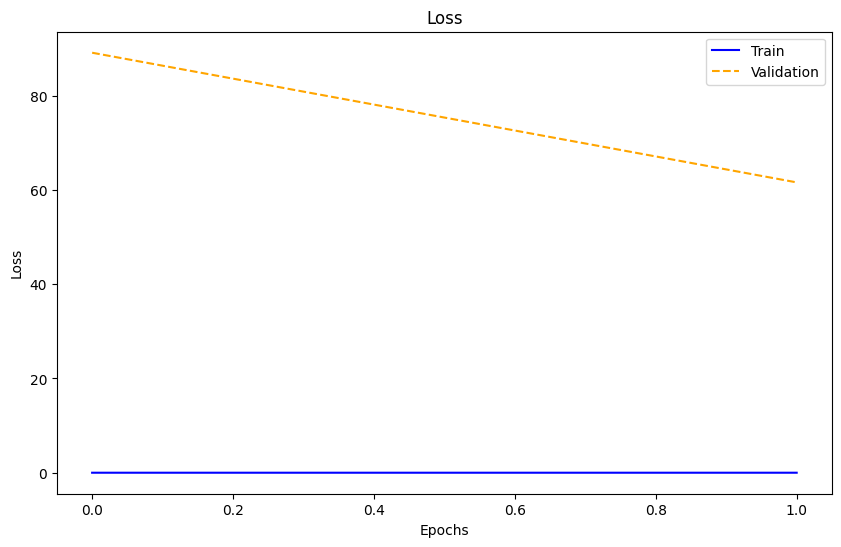

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(loss_history_train, label='Train', color='blue')
plt.plot(loss_history_val, label='Validation', color='orange', linestyle = '--')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

In [44]:
# print(NSE_val[:-10])

In [45]:
# import csv

# def save_last_10_values_and_avg_to_csv(NSE_train_value, NSE_val_value, output_csv_file):

#     # Ensure both lists have at least 10 values
#     if len(NSE_train_value) < 10 or len(NSE_val_value) < 10:
#         raise ValueError("Both lists must have at least 10 values.")
    
#     # Extract the last 10 values
#     last_10_train = NSE_train_value[-10:]
#     last_10_val = NSE_val_value[-10:]
    
#     # Compute averages
#     avg_train = sum(last_10_train) / 10
#     avg_val = sum(last_10_val) / 10
    
#     # Write the data to a CSV file
#     with open(output_csv_file, mode='w', newline='') as csvfile:
#         writer = csv.writer(csvfile)
        
#         # Write headers
#         writer.writerow(["Metric", "Values", "Average"])
        
#         # Write last 10 values and average for training data
#         writer.writerow(["NSE_train_last_10", ", ".join(map(str, last_10_train)), avg_train])
        
#         # Write last 10 values and average for validation data
#         writer.writerow(["NSE_val_last_10", ", ".join(map(str, last_10_val)), avg_val])
    
#     print(f"Last 10 values and averages saved to {output_csv_file}")



# # Example usage:
# save_last_10_values_and_avg_to_csv(NSE_train, NSE_val, "Results/average_values_combined")

In [46]:
# val_loader, np_val_seq_X, np_val_seq_y = make_data_loader([3])  ##
#plot_bucket = [115]
#test_data_x, test_data_y = concatanate_tensors(val_loader, plot_bucket)
#test_dataset = torch.utils.data.TensorDataset(test_data_x, test_data_y)
#test_batch_loader = torch.utils.data.DataLoader(test_dataset, batch_size= batch_size)

In [56]:
#print(network_dict[0])
model.eval()
with torch.no_grad():
    with tqdm(test_loader, unit="batch") as testbar:
        for data, targets in test_loader:
            testbar.set_description("Testing!")
            
            test_data_x = data.to(device=device)
            test_data_y = targets.to(device=device)

            # test_data_x, test_data_y = test_data_x.to(device)
            predicted_y_untransformed = model(test_data_x)
            predicted_y_untransformed = predicted_y_untransformed.reshape(1, -1)
            predicted_y_untransformed = predicted_y_untransformed.to("cpu")
            predicted_y_untransformed = predicted_y_untransformed.numpy()
            predicted_y = inverse_scale(scaler_out, predicted_y_untransformed)

            test_data_y = test_data_y.reshape(1, -1)
            test_data_y = test_data_y.to("cpu").numpy()
            test_data_y = inverse_scale(scaler_out, test_data_y)

            testbar.update(1)


  0%|          | 0/344 [00:00<?, ?batch/s]

In [57]:
#x = []
#test_data_y = test_data_y.reshape(test_data_y.shape[0])
#predicted_y = predicted_y.reshape(predicted_y.shape[0])

print(calculate_NSE(test_data_y, predicted_y))
#predicted_y = predicted_y.reshape(predicted_y.shape[0])

-4.2733878e+27


In [40]:
# rain_rate  = network_dict[plot_bucket]['RAINRATE_x'][270:744].to_list()

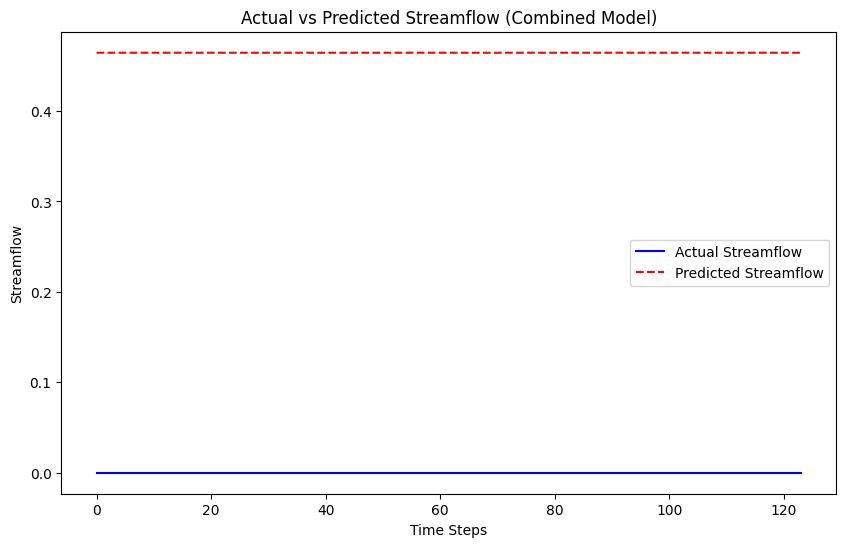

In [70]:
import matplotlib.pyplot as plt

# Plot the actual and predicted streamflow values
plt.figure(figsize=(10, 6))
plt.plot(test_data_y[0], label='Actual Streamflow', color='blue')
plt.plot(predicted_y[0], label='Predicted Streamflow', color='red', linestyle='--')
# plt.plot(rain_rate, color='yellow', linestyle='--')

# Adding labels and title
plt.xlabel('Time Steps')
plt.ylabel('Streamflow')
plt.title('Actual vs Predicted Streamflow (Combined Model)')
plt.legend()


In [42]:
# import matplotlib.pyplot as plt

# # Create the figure and the primary axis
# fig, ax1 = plt.subplots(figsize=(10, 6))

# # Plot test_data_y (Actual Streamflow) on the primary y-axis
# ax1.plot(test_data_y, label='Actual Streamflow', color='blue')
# ax1.set_xlabel('Time Steps')
# ax1.set_ylabel('Streamflow (Actual)', color='blue')
# ax1.tick_params(axis='y', labelcolor='blue')
# ax1.set_title('Actual vs Predicted Streamflow with Rain Rate')
# ax1.legend(['Actual Streamflow'], loc='upper left')

# # Create a secondary y-axis for predicted_y
# ax2 = ax1.twinx()
# ax2.plot(predicted_y, label='Predicted Streamflow', color='red', linestyle='--')
# ax2.plot(rain_rate, label='Rain Rate', color='yellow', linestyle=':')
# ax2.set_ylabel('Streamflow (Predicted) and Rain Rate', color='red')
# ax2.tick_params(axis='y', labelcolor='red')
# ax2.legend(['Predicted Streamflow', 'Rain Rate'], loc='upper right')

plt.show()
